Assignment 2, Stochastic gradient descent<br>
Allison Hwang and Albert Kuo


In [10]:
import base64
import json
import numpy
import random
from pyspark.mllib.clustering import KMeans
import matplotlib as plt

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
def parse(x):
   digit = json.loads(x)
   array = numpy.fromstring(base64.b64decode(digit["data"]),
     dtype=numpy.ubyte)
   return (digit["label"], array)

digits = sc.textFile("s3n://stat-37601/digits.base64.json")

In [12]:
# split into training and test set
seed = random.randint(0,10000)
train = digits.sample(False, 0.75, seed)
test = digits.subtract(train).map(parse)
train = train.map(parse)
train_data = train.map(lambda x: x[1])
digits = digits.map(parse)

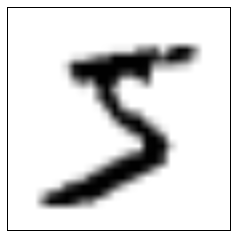

In [13]:
images = digits.take(1)
for i in range(1):
    image = images[i][1]
    image = image.astype(float)/256
    plt.figure(i)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

###A) determine what label matches each center most closely in the training set.
Using the empirical risk criterion, empirical risk is minimized when the center's chosen label causes the least number of errors among the data points associated with that cluster.  

In [14]:
clusters = KMeans.train(train_data, 10, maxIterations=50, runs=10, initializationMode="random")

In [ ]:
t_data = train.collect()

In [ ]:
# det the cluster labels
def cluster_labels(kmeans_clusters, train_data):
    n = len(kmeans_clusters.centers)
    cluster_labels = [0] * n
    cluster_d = {}
    for i in range(0,n):
        cluster_d[i] = [0]*10
    
    for point in train_data:
        cluster_num = kmeans_clusters.predict(point[1])
        y = point[0]
        cluster_d[cluster_num][y] += 1
    
    return cluster_d
cd = cluster_labels(clusters, t_data)

In [ ]:
# using empirical risk criterion, which center matches w/ which label 
def center_labels(center_dict):
    labels = []
    n = len(center_dict)
    for i in range(0, n):
        max_label = 0
        label = 0
        for j in range(0, 10):
            if center_dict[i][j] > max_label:
                max_label = center_dict[i][j]
                label = j
        labels.append(label)
    return labels

c_labels = center_labels(cd)
print c_labels

###B) Print out the clusters and display the labels you inferred above, and compare them to the pictures.

[1, 2, 7, 9, 1, 4, 8, 6, 0, 3]


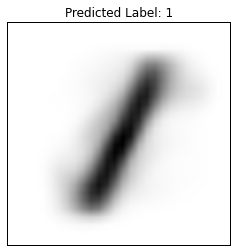

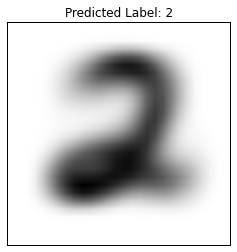

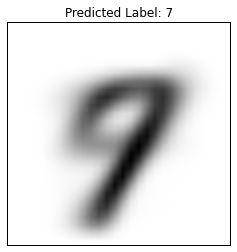

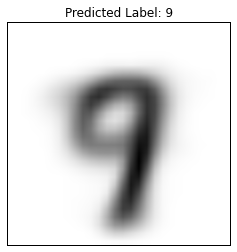

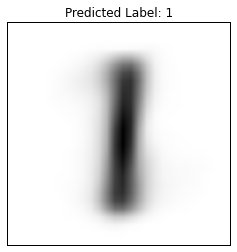

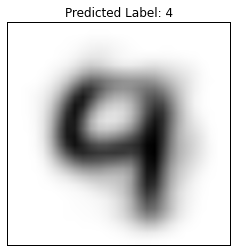

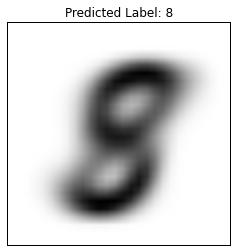

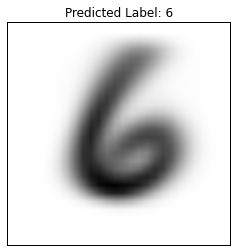

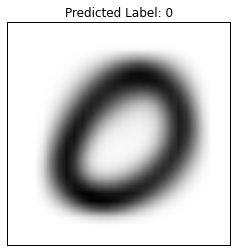

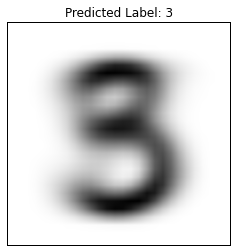

In [9]:
# print the cluster centers with predicted labels

for i in range(0, 10):
    image = clusters.centers[i]
    image = image.astype(float)/256

    title= "Predicted Label: " + str(c_labels[i])
    plt.figure(i)
    plt.title(title)
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)


In [10]:
# use classifiers on development set
d_data = test.collect()

### C) Compute the error rate of the clustering using the inferred labels on the development set. The error is just the number of wrongly-classified labels.

In [11]:
def error_rate(predicted_labels, test_data):
    n = len(clusters.centers)
    error = 0
    for point in test_data:
        cluster_num = clusters.predict(point[1])
        y = point[0]
        yhat = predicted_labels[cluster_num]
        if yhat != y:
            error += 1
    return error
error_rate(c_labels, d_data)

6224

The following code is trying to pinpoint what k values are best for clustering. I try many values and then plot them.

In [12]:
def cluster_error(clusters, train_data, test_data):
    # using empirical risk criterion, which center matches w/ which label 
    center_d = cluster_labels(clusters, train_data)
    predicted_labels = center_labels(center_d)
    print predicted_labels
    error = error_rate(predicted_labels, test_data)
    return error

In [12]:
prelim_k = [5, 10, 20, 30, 40]
errors = []

In [58]:
for k in prelim_k:
    clusters = KMeans.train(train_data, k, maxIterations=50, runs=10, initializationMode="random")
    error = cluster_error(clusters, t_data, d_data)
    print error
    errors.append(error)

[3, 7, 1, 0, 6]
8198
[1, 7, 6, 2, 3, 8, 0, 4, 0, 1]
6075
[6, 2, 1, 0, 0, 3, 3, 5, 7, 9, 4, 4, 6, 5, 2, 8, 7, 0, 1, 8]
4096
[0, 1, 9, 8, 7, 9, 0, 6, 3, 5, 0, 4, 7, 0, 1, 6, 6, 4, 1, 2, 2, 8, 3, 2, 2, 3, 5, 7, 3, 4]
3799
[2, 5, 7, 7, 8, 7, 9, 9, 2, 5, 0, 6, 2, 8, 3, 7, 9, 1, 3, 0, 4, 2, 6, 2, 8, 3, 2, 0, 6, 0, 6, 1, 3, 7, 6, 1, 1, 5, 4, 4]
3133


In [61]:
second_k = [60, 80, 100]
for k in second_k:
    clusters = KMeans.train(train_data, k, maxIterations=50, runs=10, initializationMode="random")
    error = cluster_error(clusters, t_data, d_data)
    print error
    errors.append(error)

[8, 5, 7, 0, 0, 1, 5, 4, 2, 4, 0, 1, 9, 5, 3, 2, 3, 9, 8, 1, 4, 2, 2, 6, 6, 3, 3, 1, 5, 8, 0, 7, 3, 8, 2, 6, 6, 7, 6, 4, 2, 4, 0, 8, 7, 2, 8, 8, 7, 0, 2, 6, 3, 5, 6, 9, 9, 4, 9, 5]
2464
[1, 0, 9, 9, 2, 9, 5, 3, 8, 9, 8, 2, 7, 5, 5, 5, 2, 6, 1, 2, 3, 7, 3, 1, 4, 8, 9, 8, 9, 6, 4, 1, 6, 6, 0, 6, 8, 2, 3, 3, 3, 4, 1, 0, 6, 3, 6, 7, 0, 8, 7, 5, 7, 2, 7, 0, 9, 3, 7, 2, 3, 8, 2, 5, 0, 2, 4, 6, 8, 4, 5, 1, 6, 1, 4, 5, 4, 0, 2, 0]
2306
[6, 5, 9, 6, 0, 5, 1, 7, 1, 3, 3, 5, 2, 4, 9, 7, 0, 7, 1, 6, 5, 4, 8, 3, 2, 4, 6, 2, 4, 9, 8, 0, 6, 6, 7, 2, 8, 2, 1, 1, 3, 1, 2, 9, 3, 0, 0, 2, 7, 1, 0, 0, 2, 3, 8, 0, 3, 7, 7, 1, 4, 5, 9, 2, 9, 8, 1, 9, 4, 8, 9, 4, 2, 2, 7, 3, 0, 1, 4, 0, 7, 9, 9, 8, 3, 6, 8, 2, 5, 8, 5, 5, 5, 6, 4, 5, 6, 4, 2, 4]
1940


In [19]:
fourth_k = [400]
for k in third_k:
    clusters = KMeans.train(train_data, k, maxIterations=50, runs=5, initializationMode="random")
    error = cluster_error(clusters, t_data, d_data)
    print error


[3, 2, 8, 0, 9, 1, 2, 7, 0, 0, 0, 6, 9, 0, 8, 0, 4, 6, 4, 5, 8, 5, 1, 5, 2, 0, 7, 2, 0, 9, 0, 9, 6, 5, 2, 5, 5, 7, 9, 5, 7, 5, 7, 1, 6, 1, 7, 0, 7, 9, 8, 8, 6, 2, 2, 8, 9, 6, 4, 1, 0, 4, 3, 2, 3, 6, 5, 2, 1, 2, 4, 8, 0, 5, 6, 3, 3, 0, 0, 3, 9, 1, 2, 9, 2, 4, 8, 4, 1, 6, 1, 9, 2, 1, 7, 2, 7, 5, 8, 4, 7, 6, 6, 1, 9, 6, 1, 4, 6, 6, 7, 3, 3, 1, 4, 8, 3, 2, 8, 2, 7, 7, 5, 6, 4, 4, 2, 8, 7, 5, 2, 8, 7, 3, 5, 2, 3, 6, 4, 5, 7, 2, 7, 5, 2, 4, 3, 1, 9, 4, 2, 4, 9, 9, 0, 6, 8, 5, 0, 9, 8, 0, 4, 6, 0, 7, 9, 3, 6, 7, 0, 9, 5, 0, 0, 3, 4, 6, 6, 1, 9, 5, 8, 6, 9, 9, 0, 6, 3, 4, 2, 3, 7, 4, 7, 0, 5, 1, 3, 9]
1469


In [13]:
clusters = KMeans.train(train_data, 150, maxIterations=50, runs=5, initializationMode="random")
error = cluster_error(clusters, t_data, d_data)
print error

[5, 0, 8, 2, 2, 1, 9, 2, 9, 8, 4, 9, 2, 6, 9, 5, 6, 5, 2, 0, 1, 8, 4, 8, 6, 0, 1, 6, 6, 5, 9, 7, 0, 4, 9, 2, 1, 5, 3, 1, 1, 1, 9, 0, 1, 9, 7, 4, 5, 6, 7, 2, 5, 3, 9, 2, 4, 8, 3, 1, 5, 8, 5, 4, 6, 3, 2, 4, 7, 6, 7, 3, 5, 5, 0, 0, 6, 4, 9, 2, 6, 3, 1, 8, 6, 3, 8, 2, 8, 7, 3, 2, 0, 0, 4, 3, 4, 2, 9, 8, 6, 7, 8, 1, 0, 3, 5, 0, 5, 8, 7, 2, 2, 2, 0, 3, 4, 5, 2, 6, 4, 4, 9, 3, 3, 8, 7, 0, 2, 1, 2, 7, 3, 8, 7, 5, 7, 3, 2, 3, 4, 5, 9, 0, 0, 9, 3, 4, 5, 7]
1661


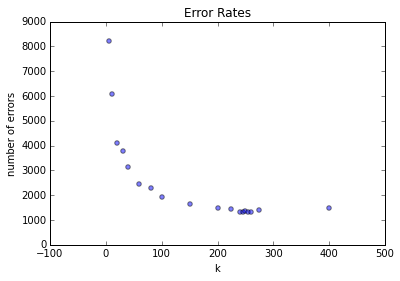

In [9]:
x = [5, 10, 20, 30, 40, 60, 80, 100, 150, 200, 225, 240, 245, 250, 255, 260, 275, 400]
errors = [8198, 6075, 4096, 3799, 3133, 2464, 2306, 1940, 1661, 1473, 1443, 1325, 1342, 1383,1329,1327,1408, 1469]
plt.scatter(x, errors, alpha=0.5)
plt.title('Error Rates')
plt.xlabel('k')
plt.ylabel('number of errors')

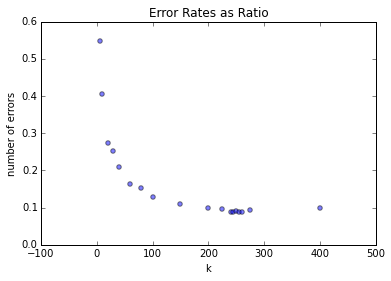

In [5]:
x = [5, 10, 20, 30, 40, 60, 80, 100, 150, 200, 225, 240, 245, 250, 255, 260, 275, 400]
errors = [8198, 6075, 4096, 3799, 3133, 2464, 2306, 1940, 1661, 1473, 1443, 1325, 1342, 1383,1329,1327,1408, 1469]
errors = numpy.divide(errors,15000.0)
plt.scatter(x, errors, alpha=0.5)
plt.title('Error Rates as Ratio')
plt.xlabel('k')
plt.ylabel('number of errors')

It seems that values of k around 240 produce the best error rates. k=240 produced 1325 errors when I ran k-means clustering on it. Error rates continue decreasing afterward but very slowly. It takes too long for me to run the algorithm with k values much greater than 200, so I cannot confidently extrapolate the current data points.